# Make a dataset from an image using OSM markup

We can easily make a dataset of some objects using existing (though imperfect) markup available at OpenStreetMap.

What we will need is overpass-turbo tool (with http API) and OSM wiki.
Using this tool, we can export any map data from OSM, and at the wiki we can find all the info to filter the data.

For example, let's make a dataset with the road markup for an existing image that we got from the Digital Globe (now Maxar) Open Data program.


# Data folder definition - change it for yourself!

In [2]:
import os

import rasterio
from aeronet.dataset import rasterize, Band
from aeronet.converters.split import split

In [4]:
RGB_IMAGE = ''
DATASET_FOLDER = ''
os.makedirs(DATASET_FOLDER, exist_ok=True)

# Download data from google drive

# Split the RGB image into channels

In [ ]:
split(RGB_IMAGE, DATASET_FOLDER, ['RED', 'GRN', 'BLU'])

# Locate the file and get the bbox

In [ ]:
# This 
def get_latlon_bounds(image_name):
    with rasterio.open(image_name) as src:
        bounds = src.bounds
        crs = src.crs
    bounds_latlon = rasterio.warp.transform_bounds(crs, 'epsg:4326', *bounds)
    print(f'Bounds: {bounds_latlon}')
    return f'{bounds_latlon[1]}, {bounds_latlon[0]}, {bounds_latlon[3]}, {bounds_latlon[2]}'

bbox = get_latlon_bounds(RGB_IMAGE)

# Get the results of overpass-turbo request

First, we need to form the query.
I want to get all the roads intended for cars, so looking through the wiki page https://wiki.openstreetmap.org/wiki/Key:highway I exclude the pedestrian variants.

Note the types of the geometries you need. In our case, it is the `way` type - linear object. Some objects can be `node`s of `area`s, or maybe even relations, and you will need to change the request.

If you need your request to meet all the conditions ('AND'), place them one after another in one line;
If you need 'OR' condition, make it two separate lines with their own set of keys.

You can use https://overpass-turbo.eu web-interface to see the results before requesting the API.



In [3]:
import requests
import json

overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = """
[out:json];
way["highway"]["highway"!~"track"]["highway"!~"pedestrian"]["highway"!~"footway"]["highway"!~"steps"]["highway"!~"path"]["highway"!~"proposed"]["highway"!~"construction"]({},{},{},{});
out geom;
""".format(bbox[1], bbox[0], bbox[3], bbox[2]')
# Note that bbox order is not the same as in rasterio. It is a common problem, so be careful!
           
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()
tmp_file = os.path.join(DATASET_FOLDER, 'tmp.json')
with open(tmp_file, 'w') as dst:
    dst.write(json.dumps(data))

# Transform the data to geojson via js package

[out:json] in the request makes overpass to return the coordinates in json format, however it is not geojson, so in order to handle the geometries we will need to convert it using the tool (written in node.js so we need npm to install it)

In [ ]:
! sudo apt install npm
! npm install -g osmtogeojson

In [6]:
markup_file = os.path.join(DATASET_FOLDER, '307.geojson')
os.system(f'osmtogeojson {tmp_file} > {markup_file}')

/bin/sh: 1: osmtogeojson: not found


# Clean the features from unused properties
## We leave only the 'highway' tag for road class to derive the width and 'surface' to distinguish between asphalt and gravel roads, maybe in future

All the other tags do not matter for us this time, and also some of them (associated with local names) can be non-ascii, which is not very convenient.

In [11]:
import geojson
import io

with io.open(markup_file, encoding='utf-8') as src:
    geo_data = geojson.loads(src.read())
    
feats = []
for feat in geo_data.features:
    feats.append(geojson.Feature(geometry=feat.geometry, 
                 properties={'highway':feat.properties.get('highway', ''),
                             'surface':feat.properties.get('surface', '')}))
    
new_geo_data = geojson.FeatureCollection(features = feats)

# Display the data

In [32]:
from shapely.geometry import shape

shapes = [shape(feat.geometry) for feat in new_geo_data.features]

In [36]:
[feat for feat in new_geo_data.features if feat.geometry['type'] == 'Polygon']

[{"geometry": {"coordinates": [[[37.267552, 55.036262], [37.2674801, 55.0361563], [37.2677709, 55.0360913], [37.2678429, 55.036197], [37.267552, 55.036262]]], "type": "Polygon"}, "properties": {"highway": "service", "surface": ""}, "type": "Feature"},
 {"geometry": {"coordinates": [[[37.2637475, 55.1847301], [37.2636764, 55.1847026], [37.2639084, 55.1844909], [37.2642537, 55.1846237], [37.2644193, 55.184489], [37.2645226, 55.1845249], [37.2643007, 55.1847296], [37.2641391, 55.1848787], [37.2640156, 55.1848488], [37.2637475, 55.1847301]]], "type": "Polygon"}, "properties": {"highway": "service", "surface": ""}, "type": "Feature"},
 {"geometry": {"coordinates": [[[37.2612396, 55.1857424], [37.2616473, 55.1857179], [37.2616795, 55.1859047], [37.2614887, 55.1859179], [37.2612718, 55.1859292], [37.2612396, 55.1857424]]], "type": "Polygon"}, "properties": {"highway": "service", "surface": ""}, "type": "Feature"}]

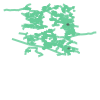

In [37]:
from shapely.ops import unary_union

unary_union(shapes)

# Divide the data by tags

The roads by now are displayed as lines, but we want to create a segmentation dataset, so we need them to be area objects, that is to have width. The width will depend on the road type: the primary roads will be 40 meters wide, secondary - 20 meters and the small links will have 10 meters in width. This is very approximate, but there are bigger issues like shift, so it will do

In [5]:
all_tags = set()

for feat in new_geo_data.features:
    all_tags.add(feat.properties['highway'])
    
all_tags

NameError: name 'new_geo_data' is not defined

However we do not have the full set of tags in this area, so let's go back to wiki and fill the classes from it

In [43]:
wide = ['primary', 'trunk', 'motorway']
medium = ['secondary','tertiary', 
          'trunk_link', 'motorway_link', 'primary_link']
slim = ['tertiary_link', 'secondary_link',
        'unclassified', 'road','residential', 
        'living_street', 'service', 'bus_guideway']

In [44]:
wide_roads = [feat for feat in new_geo_data.features if feat.properties['highway'] in wide]
medium_roads = [feat for feat in new_geo_data.features if feat.properties['highway'] in medium]
slim_roads = [feat for feat in new_geo_data.features if feat.properties['highway'] in slim]

# This is to know if we have lost something important
other = [feat for feat in new_geo_data.features if feat.properties['highway'] not in wide+medium+slim]

# Making the polygons from roads with buffer()

We use a simple memo that 1 degree is about 111 km, so 10 meters is kind of 0.0001 degrees

In [58]:
# We also can make the file more compact by changing default buffer() parameters and further simplifying the geometry, 
# but in this case it is not important at all


from aeronet.dataset import FeatureCollection, Feature


fc_wide = FeatureCollection([Feature(shape(feat.geometry).buffer(0.0002), properties=feat.properties) for feat in wide_roads])
fc_med = FeatureCollection([Feature(shape(feat.geometry).buffer(0.0001), properties=feat.properties) for feat in medium_roads])
fc_sl = FeatureCollection([Feature(shape(feat.geometry).buffer(0.00005), properties=feat.properties) for feat in slim_roads])

In [59]:
# We use aeronet FeatureCollection to make easy transfer from shapely polygons to geojson file, like this
fc_all = fc_wide

fc_all.extend(fc_med)
fc_all.extend(fc_sl)
fc_all.save('/home/user/data/tmp/roads_poly.geojson')

# All we need now is to create a mask

and aeronet library will help a lot here

In [ ]:
# Open the file as Band to get the raster parameters
band = Band(RGB_IMAGE) 
# rasterize the FeatureCollection (note the reprojection!)
rasterize(fc_all.reproject(band.crs), 
          band.transform, 
          band.shape, 
          name = '307').save(folder)


# Let's see what we got

# Functions...

In [90]:
import rasterio
from aeronet.dataset import rasterize, Band

def get_latlon_bounds(image_name):
    with rasterio.open(image_name) as src:
        bounds = src.bounds
        crs = src.crs
    bounds_latlon = rasterio.warp.transform_bounds(crs, 'epsg:4326', *bounds)
    print(f'Bounds: {bounds_latlon}')
    return f'{bounds_latlon[1]}, {bounds_latlon[0]}, {bounds_latlon[3]}, {bounds_latlon[2]}'

get_latlon_bounds('/home/user/data/russia/train/001/RED.tif')

Bounds: (37.64070510864257, 55.85130522972713, 37.69598257674295, 55.88001005489419)


'55.85130522972713, 37.64070510864257, 55.88001005489419, 37.69598257674295'

In [84]:
os.system('osmtogeojson')

32512

In [93]:
import os

def get_data_from_overpass(bounds):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
    [out:json];
    way["highway"]["highway"!~"track"]["highway"!~"pedestrian"]["highway"!~"footway"]["highway"!~"steps"]["highway"!~"path"]["highway"!~"proposed"]["highway"!~"construction"]({});
    out geom;
    """.format(bounds)
    response = requests.get(overpass_url, 
                            params={'data': overpass_query})
    data = response.json()
    print(f'got data, {len(data)}')
    return data

def transform_overpass_to_geojson(data, out_filename):
    tmp_filename = '/home/user/data/tmp/data1.json'
    if os.path.exists(tmp_filename):
        os.remove(tmp_filename)
    with open(tmp_filename, 'w') as dst:
        dst.write(json.dumps(data))
    res = os.system(f'osmtogeojson {tmp_filename} > {out_filename}')    
    print(res, f'{os.path.exists(out_filename)}')

def clean_data(filename):
    # Clean the geojson data
    with io.open(filename, encoding='utf-8') as src:
        geo_data = geojson.loads(src.read())

    feats = []
    for feat in geo_data.features:
        feats.append(geojson.Feature(geometry=feat.geometry, 
                     properties={'highway':feat.properties.get('highway', ''),
                                 'surface':feat.properties.get('surface', '')}))

    new_geo_data = geojson.FeatureCollection(features = feats)
    with open(filename, 'w') as dst:
        dst.write(geojson.dumps(new_geo_data))

def make_shapes(filename, wide_buffer=0.0002, med_buffer=0.0001, slim_buffer = 0.00005):
    wide = ['primary', 'trunk', 'motorway']
    medium = ['secondary','tertiary', 
          'trunk_link', 'motorway_link', 'primary_link']
    slim = ['tertiary_link', 'secondary_link',
        'unclassified', 'road','residential', 
        'living_street', 'service', 'bus_guideway']
    
    with open(filename) as src:
        new_geo_data = geojson.loads(src.read())
    
    wide_roads = [feat for feat in new_geo_data.features if feat.properties['highway'] in wide]
    medium_roads = [feat for feat in new_geo_data.features if feat.properties['highway'] in medium]
    slim_roads = [feat for feat in new_geo_data.features if feat.properties['highway'] in slim]
    other = [feat for feat in new_geo_data.features if feat.properties['highway'] not in wide+medium+slim]
    
    if len(other) > 0:
        print(f'{len(other)} features are not classified')
    
    fc_wide = FeatureCollection([Feature(shape(feat.geometry).buffer(0.0002), 
                                         properties=feat.properties) for feat in wide_roads])
    fc_med = FeatureCollection([Feature(shape(feat.geometry).buffer(0.0001), 
                                        properties=feat.properties) for feat in medium_roads])
    fc_sl = FeatureCollection([Feature(shape(feat.geometry).buffer(0.00005), 
                                       properties=feat.properties) for feat in slim_roads])
    fc_wide.extend(fc_med)
    fc_wide.extend(fc_sl)
    
    fc_wide.save(filename)
    return fc_wide
    
def make_markup(folder, bounds=None):
    if bounds is None:
        bounds = get_latlon_bounds(os.path.join(folder, 'RED.tif'))
    data = get_data_from_overpass(bounds)
    
    markup_filename = os.path.join(folder, '307.geojson')
    transform_overpass_to_geojson(data, markup_filename)
    
    clean_data(markup_filename)
    roads = make_shapes(markup_filename)
    band = Band(os.path.join(folder, 'RED.tif'))
    
    rasterize(roads.reproject(band.crs), band.transform, band.shape, name = '307').save(folder)


In [94]:
make_markup('/home/user/data/russia_part/001/')

Bounds: (37.64070510864257, 55.85130522972713, 37.69598257674295, 55.88001005489419)
got data, 4
0 True
4 features are not classified


In [97]:
rootdir = '/home/user/data/russia/train'
for folder in os.listdir(rootdir):
    try:
        make_markup(os.path.join(rootdir, folder))
    except Exception as e:
        print(f'Element {folder} is not processed')

Bounds: (30.370159149169922, 59.71269268664053, 30.428698334663064, 59.74159812800862)
got data, 4
0 True
3 features are not classified
Bounds: (37.50406265258788, 55.59384536261828, 37.558135981600856, 55.62293682763538)
got data, 4
0 True
1 features are not classified
Bounds: (34.52668190002441, 57.57835832143147, 34.58298654452785, 57.60554575671654)
got data, 4
0 True
Bounds: (40.35218238830566, 56.12286945486011, 40.403938353133, 56.151230675476626)
got data, 4
0 True
Bounds: (73.46660614013672, 61.23833072961837, 73.52600104845108, 61.2677243627853)
got data, 4
0 True
Bounds: (38.92842292785644, 45.04531354757554, 38.97022234312214, 45.073447870376285)
got data, 4
0 True
1 features are not classified
Bounds: (65.50641059875487, 57.09867047927578, 65.56486281930901, 57.12560161256158)
got data, 4
0 True
1 features are not classified
Bounds: (36.661376953125, 56.33374366895685, 36.71424864489899, 56.36142772238543)
got data, 4
0 True
1 features are not classified
Bounds: (65.294837

In [98]:
for folder in os.listdir(rootdir):
    if not os.path.exists(os.path.join(rootdir, folder, '307.tif')):
        print (folder)

In [99]:
!tar -czpf /home/user/data/russia/russia_osm.tar.gz /home/user/data/russia/train

tar: Removing leading `/' from member names
